In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Para series de tiempo con DARTS
from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.metrics import mape, rmse, mae
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler

# Verificar disponibilidad de torch
try:
    import torch
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Usando dispositivo: {DEVICE}")
except ImportError:
    print("PyTorch no está instalado. Por favor instala torch.")
    DEVICE = "cpu"

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')  # Estilo alternativo si seaborn no está disponible
sns.set_palette("husl")

Usando dispositivo: cuda


In [15]:
# Verificar versiones instaladas
print("=== Versiones de librerías ===")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
try:
    import darts
    print(f"darts: {darts.__version__}")
except:
    print("darts: No instalado")
try:
    import torch
    print(f"torch: {torch.__version__}")
except:
    print("torch: No instalado")

=== Versiones de librerías ===
pandas: 2.2.3
numpy: 2.2.6
darts: 0.35.0
torch: 2.7.1+cu118


In [16]:
# Cargar los datos
df_train = pd.read_parquet('../../Datos/df_train.parquet')
df_test = pd.read_parquet('../../Datos/df_test.parquet')
sample_submission = pd.read_csv('../../Datos/sample_submission.csv')

print("Forma df_train:", df_train.shape)
print("Forma df_test:", df_test.shape)
print("Forma sample_submission:", sample_submission.shape)

Forma df_train: (3680, 20)
Forma df_test: (520, 19)
Forma sample_submission: (520, 2)


In [17]:
# Información básica sobre el dataset de entrenamiento
print("=== Información del Dataset de Entrenamiento ===")
print(df_train.info())
print("\n=== Primeras filas ===")
print(df_train.head())
print("\n=== Estadísticas descriptivas ===")
print(df_train.describe())

# Verificar valores nulos
print("\n=== Valores nulos por columna ===")
print(df_train.isnull().sum())

=== Información del Dataset de Entrenamiento ===
<class 'pandas.core.frame.DataFrame'>
Index: 3680 entries, 0 to 3679
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3680 non-null   object 
 1   id_bar            3680 non-null   int64  
 2   anio              3680 non-null   int64  
 3   semana            3680 non-null   UInt32 
 4   ESTRATO           3680 non-null   float64
 5   area_barrio       3680 non-null   float64
 6   dengue            3680 non-null   float64
 7   concentraciones   3680 non-null   float64
 8   vivienda          3680 non-null   float64
 9   equipesado        3680 non-null   float64
 10  sumideros         3680 non-null   float64
 11  maquina           3680 non-null   float64
 12  lluvia_mean       3680 non-null   float64
 13  lluvia_var        3680 non-null   float64
 14  lluvia_max        3680 non-null   float64
 15  lluvia_min        3680 non-null   float64
 16

In [18]:
# Crear columna de fecha a partir de año y semana
def create_date_column(df):
    """
    Crea una columna de fecha a partir de año y semana
    Maneja casos especiales como semana 53
    """
    fechas = []
    for _, row in df.iterrows():
        try:
            # Intentar crear la fecha
            fecha = datetime.strptime(f"{int(row['anio'])}-W{int(row['semana'])}-1", "%Y-W%W-%w")
        except ValueError:
            # Si hay error (por ejemplo, semana 53 en años que no la tienen), usar el último día del año
            if int(row['semana']) == 53:
                fecha = datetime(int(row['anio']), 12, 31)
            else:
                # Para otros casos, intentar aproximar
                fecha = datetime(int(row['anio']), 1, 1) + timedelta(weeks=int(row['semana'])-1)
        fechas.append(fecha)
    
    df['fecha'] = fechas
    return df

df_train = create_date_column(df_train)
df_test = create_date_column(df_test)

# Ordenar por fecha
df_train = df_train.sort_values(['id_bar', 'fecha'])
df_test = df_test.sort_values(['id_bar', 'fecha'])

print(f"Rango de fechas en train: {df_train['fecha'].min()} hasta {df_train['fecha'].max()}")
print(f"Rango de fechas en test: {df_test['fecha'].min()} hasta {df_test['fecha'].max()}")

# Verificar fechas duplicadas
print("\n=== Verificación de fechas duplicadas ===")
duplicados_train = df_train.groupby(['id_bar', 'fecha']).size()
duplicados_train = duplicados_train[duplicados_train > 1]
if len(duplicados_train) > 0:
    print(f"⚠️ Encontradas {len(duplicados_train)} combinaciones de barrio-fecha duplicadas en train")
    print("Primeras 5 duplicaciones:")
    print(duplicados_train.head())
    print("\nEstas fechas duplicadas serán manejadas automáticamente promediando los valores.")
else:
    print("✓ No hay fechas duplicadas en train")

duplicados_test = df_test.groupby(['id_bar', 'fecha']).size()
duplicados_test = duplicados_test[duplicados_test > 1]
if len(duplicados_test) > 0:
    print(f"\n⚠️ Encontradas {len(duplicados_test)} combinaciones de barrio-fecha duplicadas en test")
else:
    print("\n✓ No hay fechas duplicadas en test")

Rango de fechas en train: 2015-01-05 00:00:00 hasta 2022-01-03 00:00:00
Rango de fechas en test: 2022-01-03 00:00:00 hasta 2022-12-26 00:00:00

=== Verificación de fechas duplicadas ===
⚠️ Encontradas 30 combinaciones de barrio-fecha duplicadas en train
Primeras 5 duplicaciones:
id_bar  fecha     
0       2016-01-04    2
        2017-01-02    2
        2021-01-04    2
1       2016-01-04    2
        2017-01-02    2
dtype: int64

Estas fechas duplicadas serán manejadas automáticamente promediando los valores.

✓ No hay fechas duplicadas en test


In [19]:
# Dividir datos según el criterio especificado
train_data = df_train[df_train['anio'] < 2021].copy()
val_data = df_train[df_train['anio'] >= 2021].copy()

print(f"Datos de entrenamiento: {train_data.shape}")
print(f"Datos de validación: {val_data.shape}")
print(f"Años en entrenamiento: {sorted(train_data['anio'].unique())}")
print(f"Años en validación: {sorted(val_data['anio'].unique())}")

Datos de entrenamiento: (3150, 21)
Datos de validación: (530, 21)
Años en entrenamiento: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020)]
Años en validación: [np.int64(2021)]


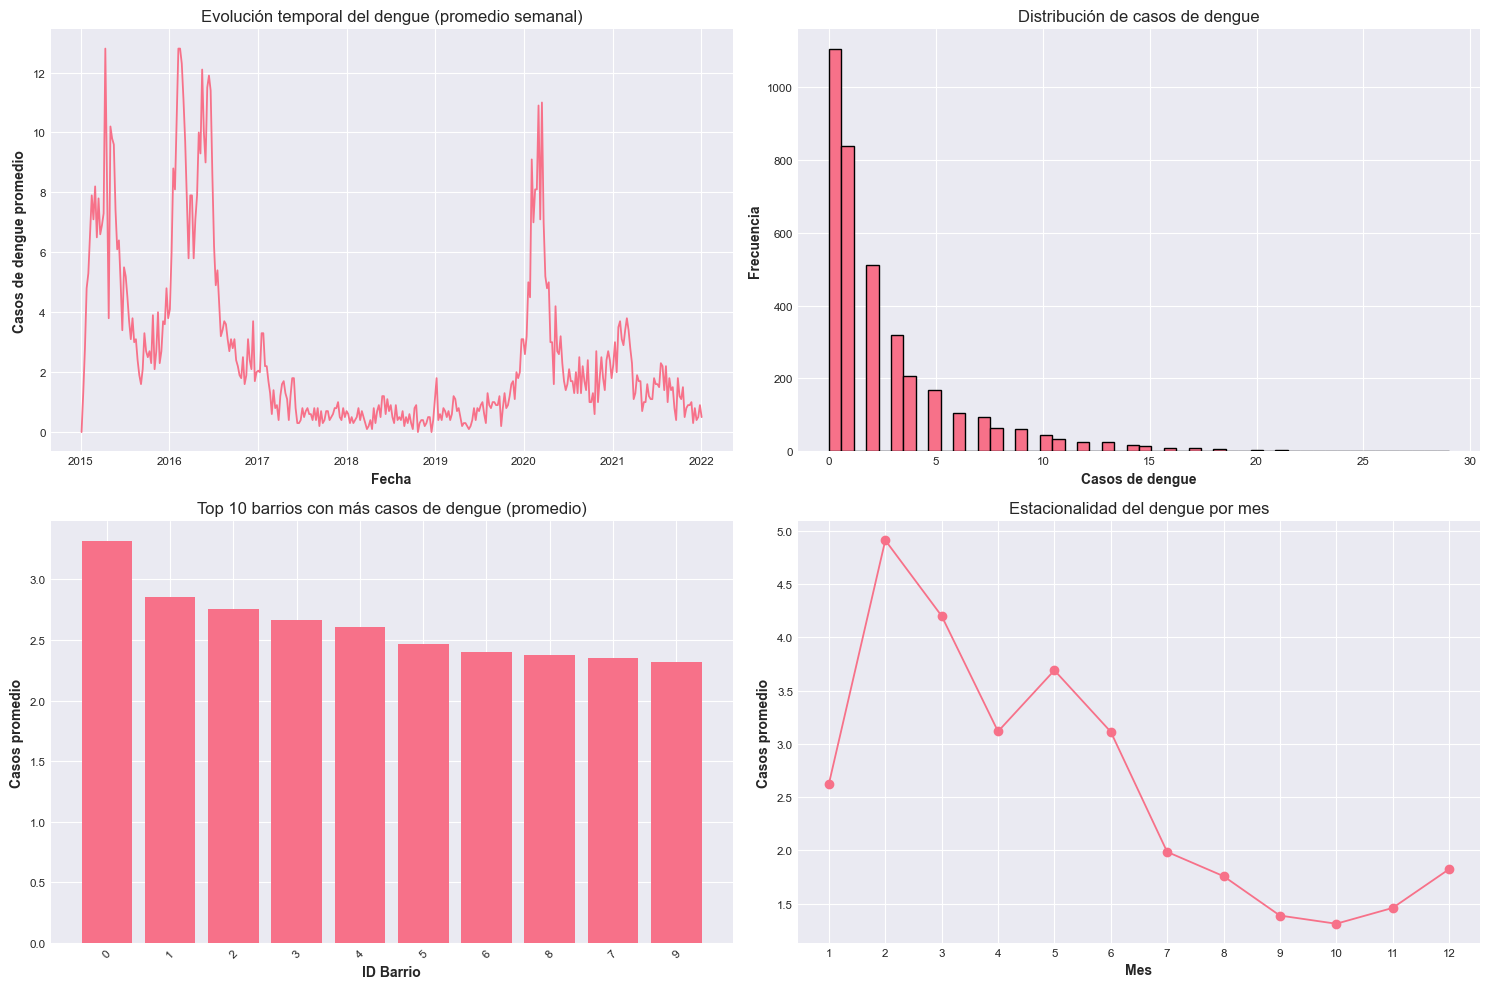

In [20]:
# Estadísticas de dengue por año
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Evolución temporal del dengue (promedio semanal)
dengue_temporal = df_train.groupby('fecha')['dengue'].mean()
axes[0, 0].plot(dengue_temporal.index, dengue_temporal.values)
axes[0, 0].set_title('Evolución temporal del dengue (promedio semanal)')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('Casos de dengue promedio')

# 2. Distribución de casos de dengue
axes[0, 1].hist(df_train['dengue'], bins=50, edgecolor='black')
axes[0, 1].set_title('Distribución de casos de dengue')
axes[0, 1].set_xlabel('Casos de dengue')
axes[0, 1].set_ylabel('Frecuencia')

# 3. Dengue por barrio (top 10)
dengue_por_barrio = df_train.groupby('id_bar')['dengue'].mean().sort_values(ascending=False).head(10)
axes[1, 0].bar(range(len(dengue_por_barrio)), dengue_por_barrio.values)
axes[1, 0].set_title('Top 10 barrios con más casos de dengue (promedio)')
axes[1, 0].set_xlabel('ID Barrio')
axes[1, 0].set_ylabel('Casos promedio')
axes[1, 0].set_xticks(range(len(dengue_por_barrio)))
axes[1, 0].set_xticklabels(dengue_por_barrio.index, rotation=45)

# 4. Estacionalidad anual
df_train['mes'] = df_train['fecha'].dt.month
dengue_por_mes = df_train.groupby('mes')['dengue'].mean()
axes[1, 1].plot(dengue_por_mes.index, dengue_por_mes.values, marker='o')
axes[1, 1].set_title('Estacionalidad del dengue por mes')
axes[1, 1].set_xlabel('Mes')
axes[1, 1].set_ylabel('Casos promedio')
axes[1, 1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

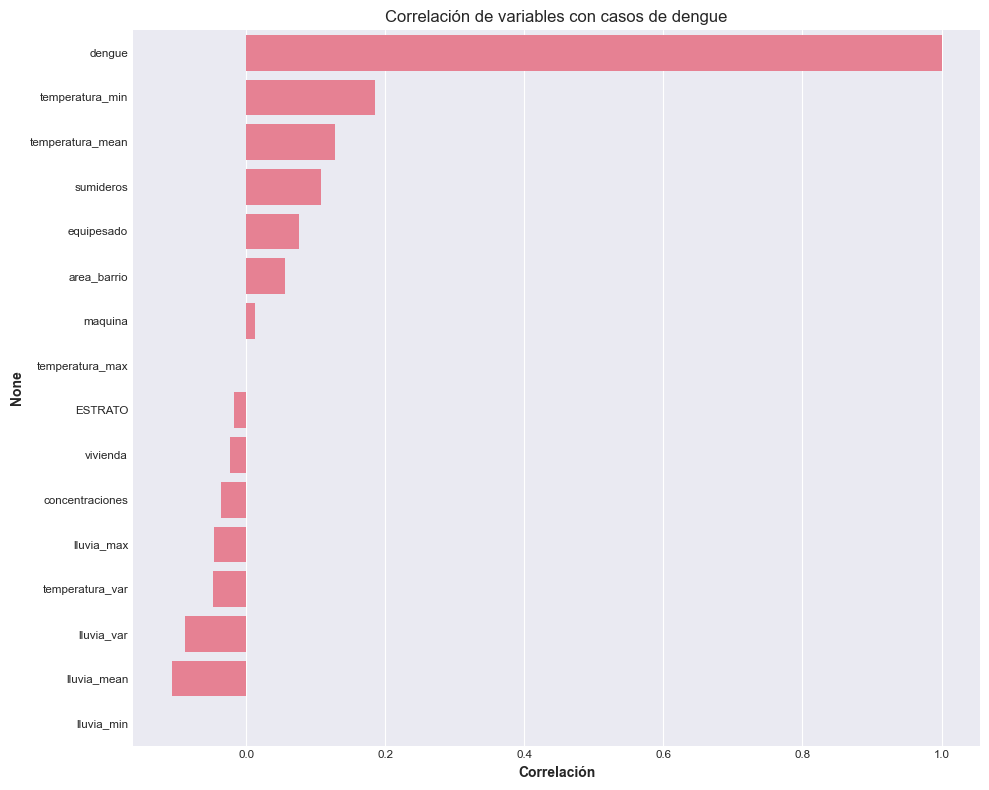

In [21]:
# Seleccionar variables numéricas relevantes
numeric_cols = ['dengue', 'ESTRATO', 'area_barrio', 'concentraciones', 'vivienda',
                'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var',
                'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var',
                'temperatura_max', 'temperatura_min']

# Calcular matriz de correlación
correlation_matrix = df_train[numeric_cols].corr()

# Visualizar correlaciones con dengue
plt.figure(figsize=(10, 8))
dengue_corr = correlation_matrix['dengue'].sort_values(ascending=False)
sns.barplot(x=dengue_corr.values, y=dengue_corr.index)
plt.title('Correlación de variables con casos de dengue')
plt.xlabel('Correlación')
plt.tight_layout()
plt.show()

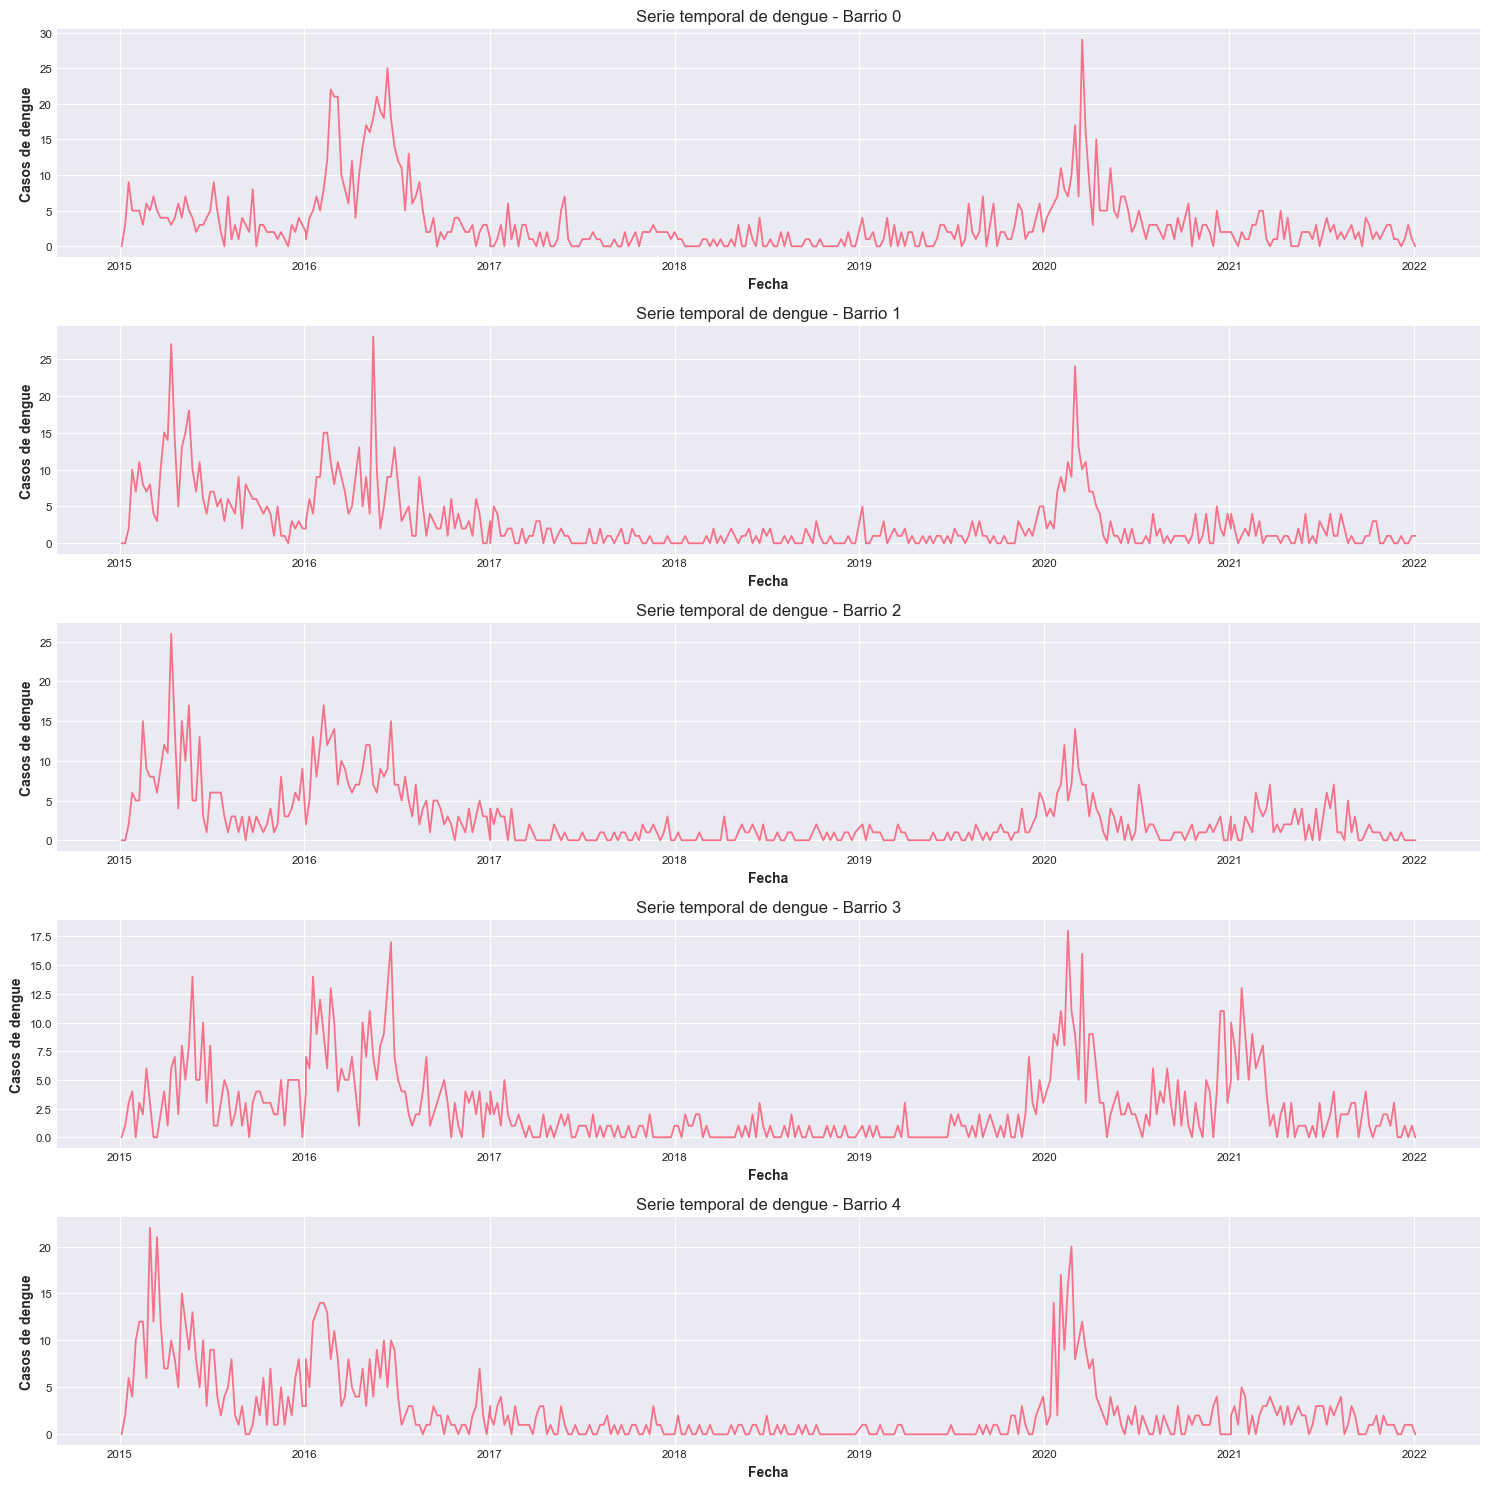

In [22]:
# Seleccionar algunos barrios representativos para visualización
top_barrios = df_train.groupby('id_bar')['dengue'].sum().sort_values(ascending=False).head(5).index

fig, axes = plt.subplots(len(top_barrios), 1, figsize=(15, 3*len(top_barrios)))
if len(top_barrios) == 1:
    axes = [axes]

for i, barrio in enumerate(top_barrios):
    barrio_data = df_train[df_train['id_bar'] == barrio].sort_values('fecha')
    axes[i].plot(barrio_data['fecha'], barrio_data['dengue'])
    axes[i].set_title(f'Serie temporal de dengue - Barrio {barrio}')
    axes[i].set_xlabel('Fecha')
    axes[i].set_ylabel('Casos de dengue')

plt.tight_layout()
plt.show()

In [23]:
# Función para crear series de tiempo por barrio
def create_time_series_by_barrio(df, target='dengue'):
    """
    Crea un diccionario de series de tiempo, una por cada barrio
    Maneja fechas duplicadas agregando los valores
    """
    series_dict = {}
    
    for barrio in df['id_bar'].unique():
        barrio_data = df[df['id_bar'] == barrio].copy()
        
        # Verificar si hay fechas duplicadas
        if barrio_data['fecha'].duplicated().any():
            print(f"Barrio {barrio}: Encontradas fechas duplicadas, agregando valores...")
            # Agrupar por fecha y tomar el promedio de las variables numéricas
            numeric_cols = barrio_data.select_dtypes(include=[np.number]).columns
            agg_dict = {col: 'mean' for col in numeric_cols if col != 'id_bar'}
            barrio_data = barrio_data.groupby('fecha').agg(agg_dict).reset_index()
        
        # Ordenar por fecha
        barrio_data = barrio_data.sort_values('fecha')
        
        # Verificar que tengamos la columna objetivo
        if target in barrio_data.columns:
            try:
                # Crear serie de tiempo
                ts = TimeSeries.from_dataframe(
                    barrio_data,
                    time_col='fecha',
                    value_cols=target,
                    freq='W-MON',
                    fill_missing_dates=True,
                    fillna_value=0  # Llenar valores faltantes con 0
                )
                
                # Solo agregar si la serie tiene suficientes datos
                if len(ts) >= 10:  # Mínimo 10 puntos de datos
                    series_dict[barrio] = ts
                else:
                    print(f"Barrio {barrio}: Serie muy corta ({len(ts)} puntos), omitiendo...")
                    
            except Exception as e:
                print(f"Error al crear serie para barrio {barrio}: {e}")
        else:
            print(f"Barrio {barrio}: No tiene datos de {target}")
    
    return series_dict

# Crear series de tiempo para entrenamiento y validación
print("Creando series de tiempo de entrenamiento...")
train_series = create_time_series_by_barrio(train_data)

print("\nCreando series de tiempo de validación...")
val_series = create_time_series_by_barrio(val_data)

print(f"\nNúmero de series de entrenamiento: {len(train_series)}")
print(f"Número de series de validación: {len(val_series)}")

# Verificar longitudes de las series
if train_series:
    longitudes = [len(ts) for ts in train_series.values()]
    print(f"Longitud promedio de series de entrenamiento: {np.mean(longitudes):.1f}")
    print(f"Longitud mínima: {np.min(longitudes)}, máxima: {np.max(longitudes)}")

Creando series de tiempo de entrenamiento...
Barrio 0: Encontradas fechas duplicadas, agregando valores...
Barrio 1: Encontradas fechas duplicadas, agregando valores...
Barrio 2: Encontradas fechas duplicadas, agregando valores...
Barrio 3: Encontradas fechas duplicadas, agregando valores...
Barrio 4: Encontradas fechas duplicadas, agregando valores...
Barrio 5: Encontradas fechas duplicadas, agregando valores...
Barrio 6: Encontradas fechas duplicadas, agregando valores...
Barrio 7: Encontradas fechas duplicadas, agregando valores...
Barrio 8: Encontradas fechas duplicadas, agregando valores...
Barrio 9: Encontradas fechas duplicadas, agregando valores...

Creando series de tiempo de validación...

Número de series de entrenamiento: 10
Número de series de validación: 10
Longitud promedio de series de entrenamiento: 314.0
Longitud mínima: 314, máxima: 314


In [24]:
# Función para crear covariables
def create_covariates(df, barrio_id):
    """
    Crea series de tiempo para las covariables de un barrio específico
    Maneja fechas duplicadas agregando los valores
    """
    barrio_data = df[df['id_bar'] == barrio_id].copy()
    
    # Manejar fechas duplicadas
    if barrio_data['fecha'].duplicated().any():
        numeric_cols = barrio_data.select_dtypes(include=[np.number]).columns
        agg_dict = {col: 'mean' for col in numeric_cols if col != 'id_bar'}
        barrio_data = barrio_data.groupby('fecha').agg(agg_dict).reset_index()
    
    # Ordenar por fecha
    barrio_data = barrio_data.sort_values('fecha')
    
    covariate_cols = ['lluvia_mean', 'lluvia_max', 'lluvia_min',
                      'temperatura_mean', 'temperatura_max', 'temperatura_min',
                      'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina']
    
    # Filtrar solo columnas que existen
    existing_cols = [col for col in covariate_cols if col in barrio_data.columns]
    
    if existing_cols:
        try:
            covariates = TimeSeries.from_dataframe(
                barrio_data,
                time_col='fecha',
                value_cols=existing_cols,
                freq='W-MON',
                fill_missing_dates=True,
                fillna_value=0  # Llenar valores faltantes
            )
            return covariates
        except Exception as e:
            print(f"Error al crear covariables para barrio {barrio_id}: {e}")
            return None
    return None

# Crear diccionarios de covariables
print("\nCreando covariables...")
train_covariates = {}
val_covariates = {}

for barrio in train_series.keys():
    train_cov = create_covariates(train_data, barrio)
    if train_cov is not None:
        train_covariates[barrio] = train_cov
    
    if barrio in val_series:
        val_cov = create_covariates(val_data, barrio)
        if val_cov is not None:
            val_covariates[barrio] = val_cov

print(f"Número de series con covariables (train): {len(train_covariates)}")
print(f"Número de series con covariables (val): {len(val_covariates)}")


Creando covariables...
Número de series con covariables (train): 10
Número de series con covariables (val): 10


In [25]:
# Crear escaladores para cada serie
scalers_target = {}
scalers_covariates = {}

# Normalizar series objetivo
normalized_train_series = {}
normalized_val_series = {}

for barrio in train_series.keys():
    # Escalar serie objetivo
    scaler = Scaler()
    normalized_train_series[barrio] = scaler.fit_transform(train_series[barrio])
    scalers_target[barrio] = scaler
    
    if barrio in val_series:
        normalized_val_series[barrio] = scaler.transform(val_series[barrio])

# Normalizar covariables
normalized_train_covariates = {}
normalized_val_covariates = {}

for barrio in train_covariates.keys():
    scaler = Scaler()
    normalized_train_covariates[barrio] = scaler.fit_transform(train_covariates[barrio])
    scalers_covariates[barrio] = scaler
    
    if barrio in val_covariates:
        normalized_val_covariates[barrio] = scaler.transform(val_covariates[barrio])

In [26]:
# Configuración común para todos los modelos
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
INPUT_CHUNK_LENGTH = 12  # Usar 12 semanas de historia
OUTPUT_CHUNK_LENGTH = 4  # Predecir 4 semanas adelante
N_RNN_LAYERS = 2
HIDDEN_DIM = 64
DROPOUT = 0.1

# Configurar modelos
try:
    models = {
        'TCN': TCNModel(
            input_chunk_length=INPUT_CHUNK_LENGTH,
            output_chunk_length=OUTPUT_CHUNK_LENGTH,
            n_epochs=EPOCHS,
            num_filters=32,
            kernel_size=3,
            dilation_base=2,
            weight_norm=True,
            num_layers=4,
            dropout=DROPOUT,
            batch_size=BATCH_SIZE,
            optimizer_kwargs={'lr': LEARNING_RATE},
            random_state=42,
            pl_trainer_kwargs={"accelerator": DEVICE}
        ),
        
        'LSTM': RNNModel(
            model="LSTM",
            input_chunk_length=INPUT_CHUNK_LENGTH,
            output_chunk_length=OUTPUT_CHUNK_LENGTH,
            n_epochs=EPOCHS,
            hidden_dim=HIDDEN_DIM,
            n_rnn_layers=N_RNN_LAYERS,
            dropout=DROPOUT,
            batch_size=BATCH_SIZE,
            optimizer_kwargs={'lr': LEARNING_RATE},
            random_state=42,
            pl_trainer_kwargs={"accelerator": DEVICE}
        ),
        
        'GRU': RNNModel(
            model="GRU",
            input_chunk_length=INPUT_CHUNK_LENGTH,
            output_chunk_length=OUTPUT_CHUNK_LENGTH,
            n_epochs=EPOCHS,
            hidden_dim=HIDDEN_DIM,
            n_rnn_layers=N_RNN_LAYERS,
            dropout=DROPOUT,
            batch_size=BATCH_SIZE,
            optimizer_kwargs={'lr': LEARNING_RATE},
            random_state=42,
            pl_trainer_kwargs={"accelerator": DEVICE}
        )
    }
except Exception as e:
    print(f"Error al configurar modelos: {e}")
    print("Intentando configuración simplificada...")
    
    # Configuración simplificada si hay problemas
    models = {
        'LSTM': RNNModel(
            model="LSTM",
            input_chunk_length=INPUT_CHUNK_LENGTH,
            output_chunk_length=OUTPUT_CHUNK_LENGTH,
            n_epochs=20,  # Menos épocas
            hidden_dim=32,  # Menos unidades
            n_rnn_layers=1,  # Menos capas
            batch_size=BATCH_SIZE,
            random_state=42
        )
    }

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


In [27]:
# Función para entrenar y evaluar un modelo en múltiples series
def train_and_evaluate_model(model, model_name, train_series, val_series, 
                           train_covariates=None, val_covariates=None, max_series=5):
    """
    Entrena un modelo en múltiples series y evalúa su rendimiento
    """
    print(f"\n=== Entrenando {model_name} ===")
    
    # Preparar listas de series para entrenamiento
    train_list = []
    val_list = []
    train_cov_list = []
    val_cov_list = []
    
    for i, barrio in enumerate(train_series.keys()):
        if i >= max_series:  # Limitar número de series para acelerar
            break
        if barrio in val_series:
            train_list.append(train_series[barrio])
            val_list.append(val_series[barrio])
            
            if train_covariates and barrio in train_covariates:
                train_cov_list.append(train_covariates[barrio])
                if val_covariates and barrio in val_covariates:
                    val_cov_list.append(val_covariates[barrio])
    
    # Entrenar modelo
    try:
        if train_cov_list:
            model.fit(
                series=train_list,
                past_covariates=train_cov_list,
                val_series=val_list,
                val_past_covariates=val_cov_list if val_cov_list else None,
                verbose=True
            )
        else:
            model.fit(
                series=train_list,
                val_series=val_list,
                verbose=True
            )
    except Exception as e:
        print(f"Error durante el entrenamiento: {e}")
        print("Intentando sin validación...")
        model.fit(series=train_list[:3], verbose=True)
    
    # Evaluar en conjunto de validación
    predictions = []
    actuals = []
    
    for i in range(min(max_series, len(val_list))):
        try:
            if train_cov_list and i < len(val_cov_list):
                pred = model.predict(
                    n=len(val_list[i]),
                    series=train_list[i],
                    past_covariates=train_cov_list[i]
                )
            else:
                pred = model.predict(
                    n=len(val_list[i]),
                    series=train_list[i]
                )
            
            predictions.append(pred)
            actuals.append(val_list[i])
        except Exception as e:
            print(f"Error en predicción para serie {i}: {e}")
    
    # Calcular métricas
    if predictions:
        rmse_scores = [rmse(actuals[i], predictions[i]) for i in range(len(predictions))]
        mae_scores = [mae(actuals[i], predictions[i]) for i in range(len(predictions))]
        
        avg_rmse = np.mean(rmse_scores)
        avg_mae = np.mean(mae_scores)
        
        print(f"{model_name} - RMSE promedio: {avg_rmse:.4f}")
        print(f"{model_name} - MAE promedio: {avg_mae:.4f}")
        
        return avg_rmse, avg_mae, model
    else:
        return float('inf'), float('inf'), model

# Entrenar todos los modelos
results = {}

# Ajustar número de series según recursos disponibles
MAX_SERIES_TO_TRAIN = 5  # Puedes aumentar este número si tienes más recursos

for model_name, model in models.items():
    try:
        rmse_score, mae_score, trained_model = train_and_evaluate_model(
            model, 
            model_name,
            normalized_train_series,
            normalized_val_series,
            normalized_train_covariates,
            normalized_val_covariates,
            max_series=MAX_SERIES_TO_TRAIN
        )
        
        results[model_name] = {
            'rmse': rmse_score,
            'mae': mae_score,
            'model': trained_model
        }
    except Exception as e:
        print(f"Error al entrenar {model_name}: {e}")
        results[model_name] = {
            'rmse': float('inf'),
            'mae': float('inf'),
            'model': None
        }

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 20.6 K | train
------------


=== Entrenando TCN ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
ValueError: For the given forecasting horizon `n=53`, the provided past covariates at dataset index `0` do not extend far enough into the future. As `n > output_chunk_length` the past covariates must end at time step `2021-12-13 00:00:00`, whereas now they end at time step `2021-01-04 00:00:00`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
ValueError: For

Error en predicción para serie 0: For the given forecasting horizon `n=53`, the provided past covariates at dataset index `0` do not extend far enough into the future. As `n > output_chunk_length` the past covariates must end at time step `2021-12-13 00:00:00`, whereas now they end at time step `2021-01-04 00:00:00`.
Error en predicción para serie 1: For the given forecasting horizon `n=53`, the provided past covariates at dataset index `0` do not extend far enough into the future. As `n > output_chunk_length` the past covariates must end at time step `2021-12-13 00:00:00`, whereas now they end at time step `2021-01-04 00:00:00`.
Error en predicción para serie 2: For the given forecasting horizon `n=53`, the provided past covariates at dataset index `0` do not extend far enough into the future. As `n > output_chunk_length` the past covariates must end at time step `2021-12-13 00:00:00`, whereas now they end at time step `2021-01-04 00:00:00`.
Error en predicción para serie 3: For the g

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.
ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.
ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.
ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.
ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.
ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0 

Error en predicción para serie 0: The model does not support `past_covariates`. It only supports `future_covariates`.
Error en predicción para serie 1: The model does not support `past_covariates`. It only supports `future_covariates`.
Error en predicción para serie 2: The model does not support `past_covariates`. It only supports `future_covariates`.
Error en predicción para serie 3: The model does not support `past_covariates`. It only supports `future_covariates`.
Error en predicción para serie 4: The model does not support `past_covariates`. It only supports `future_covariates`.

=== Entrenando GRU ===
Error durante el entrenamiento: The model does not support `past_covariates`. It only supports `future_covariates`.
Intentando sin validación...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.
ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.
ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.
ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.
ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.


Error en predicción para serie 0: The model does not support `past_covariates`. It only supports `future_covariates`.
Error en predicción para serie 1: The model does not support `past_covariates`. It only supports `future_covariates`.
Error en predicción para serie 2: The model does not support `past_covariates`. It only supports `future_covariates`.
Error en predicción para serie 3: The model does not support `past_covariates`. It only supports `future_covariates`.
Error en predicción para serie 4: The model does not support `past_covariates`. It only supports `future_covariates`.


In [29]:
# Filtrar solo modelos que se entrenaron exitosamente
valid_results = {k: v for k, v in results.items() if v['model'] is not None and v['rmse'] != float('inf')}

if valid_results:
    # Visualizar resultados
    metrics_df = pd.DataFrame({
        'Model': list(valid_results.keys()),
        'RMSE': [valid_results[m]['rmse'] for m in valid_results.keys()],
        'MAE': [valid_results[m]['mae'] for m in valid_results.keys()]
    })
    
    print("\n=== Comparación de Modelos ===")
    print(metrics_df)
    
    # Encontrar el mejor modelo
    best_model_name = metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Model']
    best_model = valid_results[best_model_name]['model']
    print(f"\nMejor modelo: {best_model_name}")
else:
    print("\n⚠️ Ningún modelo se entrenó exitosamente. Usando modelo por defecto...")
    # Crear un modelo simple por defecto
    best_model_name = 'LSTM_Simple'
    best_model = RNNModel(
        model="LSTM",
        input_chunk_length=8,
        output_chunk_length=1,
        n_epochs=50,
        hidden_dim=16,
        n_rnn_layers=1,
        batch_size=16,
        random_state=42
    )
    # Entrenar con datos mínimos
    train_list = list(normalized_train_series.values())[:3]
    best_model.fit(series=train_list, verbose=True)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.2 K  | train
6 | V               | Linear           | 17     | train
-------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
7         Modules in train mode
0         Modul


⚠️ Ningún modelo se entrenó exitosamente. Usando modelo por defecto...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [31]:
# Combinar train y test
df_complete = pd.concat([df_train, df_test], ignore_index=True)
df_complete = df_complete.sort_values(['id_bar', 'fecha'])

print(f"Datos completos: {df_complete.shape}")
print(f"Rango de fechas completo: {df_complete['fecha'].min()} hasta {df_complete['fecha'].max()}")

Datos completos: (4200, 22)
Rango de fechas completo: 2015-01-05 00:00:00 hasta 2022-12-26 00:00:00


In [32]:
# Para cada barrio, crear serie completa
complete_series_dict = {}
complete_covariates_dict = {}

print("Creando series completas por barrio...")
barrios_con_duplicados = 0

for barrio in df_complete['id_bar'].unique():
    barrio_data = df_complete[df_complete['id_bar'] == barrio].copy()
    
    # Verificar y manejar fechas duplicadas
    if barrio_data['fecha'].duplicated().any():
        barrios_con_duplicados += 1
        # Agrupar por fecha y promediar valores numéricos
        numeric_cols = barrio_data.select_dtypes(include=[np.number]).columns
        agg_dict = {col: 'mean' for col in numeric_cols if col != 'id_bar'}
        # Para la columna objetivo, si hay NaN (del test), ignorarlos en el promedio
        if 'dengue' in agg_dict:
            agg_dict['dengue'] = lambda x: x.mean() if not x.isna().all() else 0
        barrio_data = barrio_data.groupby('fecha').agg(agg_dict).reset_index()
    
    # Ordenar por fecha
    barrio_data = barrio_data.sort_values('fecha')
    
    # Para la serie objetivo, llenar los NaN del test con 0 temporalmente
    if 'dengue' in barrio_data.columns:
        barrio_data['dengue'] = barrio_data['dengue'].fillna(0)
    else:
        barrio_data['dengue'] = 0
    
    try:
        # Crear serie de tiempo
        ts = TimeSeries.from_dataframe(
            barrio_data,
            time_col='fecha',
            value_cols='dengue',
            freq='W-MON',
            fill_missing_dates=True,
            fillna_value=0
        )
        
        # Crear covariables
        covariate_cols = ['lluvia_mean', 'lluvia_max', 'lluvia_min',
                          'temperatura_mean', 'temperatura_max', 'temperatura_min',
                          'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina']
        
        existing_cols = [col for col in covariate_cols if col in barrio_data.columns]
        
        if existing_cols:
            covariates = TimeSeries.from_dataframe(
                barrio_data,
                time_col='fecha',
                value_cols=existing_cols,
                freq='W-MON',
                fill_missing_dates=True,
                fillna_value=0
            )
            complete_covariates_dict[barrio] = covariates
        
        complete_series_dict[barrio] = ts
        
    except Exception as e:
        print(f"Error al procesar barrio {barrio}: {e}")

print(f"Barrios con fechas duplicadas: {barrios_con_duplicados}")
print(f"Series completas creadas: {len(complete_series_dict)}")

Creando series completas por barrio...
Barrios con fechas duplicadas: 10
Series completas creadas: 10


In [33]:
# Normalizar usando los escaladores ya entrenados
normalized_complete_series = {}
normalized_complete_covariates = {}

for barrio in complete_series_dict.keys():
    if barrio in scalers_target:
        # Usar el escalador existente
        normalized_complete_series[barrio] = scalers_target[barrio].transform(complete_series_dict[barrio])
    else:
        # Crear nuevo escalador para barrios nuevos
        scaler = Scaler()
        normalized_complete_series[barrio] = scaler.fit_transform(complete_series_dict[barrio])
        scalers_target[barrio] = scaler
    
    if barrio in complete_covariates_dict:
        if barrio in scalers_covariates:
            normalized_complete_covariates[barrio] = scalers_covariates[barrio].transform(complete_covariates_dict[barrio])
        else:
            scaler = Scaler()
            normalized_complete_covariates[barrio] = scaler.fit_transform(complete_covariates_dict[barrio])
            scalers_covariates[barrio] = scaler

In [35]:
# Crear nuevo modelo con la misma configuración
try:
    if best_model_name == 'TCN':
        final_model = TCNModel(
            input_chunk_length=INPUT_CHUNK_LENGTH,
            output_chunk_length=OUTPUT_CHUNK_LENGTH,
            n_epochs=EPOCHS * 2,  # Más épocas para el modelo final
            num_filters=32,
            kernel_size=3,
            dilation_base=2,
            weight_norm=True,
            num_layers=4,
            dropout=DROPOUT,
            batch_size=BATCH_SIZE,
            optimizer_kwargs={'lr': LEARNING_RATE},
            random_state=42,
            pl_trainer_kwargs={"accelerator": DEVICE}
        )
    elif best_model_name in ['LSTM', 'GRU']:
        final_model = RNNModel(
            model=best_model_name,
            input_chunk_length=INPUT_CHUNK_LENGTH,
            output_chunk_length=OUTPUT_CHUNK_LENGTH,
            n_epochs=EPOCHS * 2,  # Más épocas para el modelo final
            hidden_dim=HIDDEN_DIM,
            n_rnn_layers=N_RNN_LAYERS,
            dropout=DROPOUT,
            batch_size=BATCH_SIZE,
            optimizer_kwargs={'lr': LEARNING_RATE},
            random_state=42,
            pl_trainer_kwargs={"accelerator": DEVICE}
        )
except Exception as e:
    print(f"Error al crear modelo final: {e}")
    print("Usando modelo simplificado...")
    final_model = RNNModel(
        model="LSTM",
        input_chunk_length=INPUT_CHUNK_LENGTH,
        output_chunk_length=OUTPUT_CHUNK_LENGTH,
        n_epochs=30,
        hidden_dim=32,
        n_rnn_layers=1,
        batch_size=BATCH_SIZE,
        random_state=42
    )

# Preparar datos para entrenamiento final
final_train_series = []
final_train_covariates = []

# Usar solo los datos hasta 2021 para entrenar
for barrio in normalized_complete_series.keys():
    # Obtener serie hasta 2021
    end_date = pd.Timestamp('2021-12-31')
    series_until_2021 = normalized_complete_series[barrio].slice(
        normalized_complete_series[barrio].time_index[0],
        end_date
    )
    final_train_series.append(series_until_2021)
    
    if barrio in normalized_complete_covariates:
        cov_until_2021 = normalized_complete_covariates[barrio].slice(
            normalized_complete_covariates[barrio].time_index[0],
            end_date
        )
        final_train_covariates.append(cov_until_2021)

# Entrenar modelo final
print("\n=== Entrenando modelo final ===")
try:
    if final_train_covariates:
        final_model.fit(
            series=final_train_series,
            past_covariates=final_train_covariates,
            verbose=True
        )
    else:
        final_model.fit(
            series=final_train_series,
            verbose=True
        )
except Exception as e:
    print(f"Error durante el entrenamiento: {e}")
    print("Intentando entrenamiento con subset de datos...")
    # Entrenar con menos series si hay problemas de memoria
    final_model.fit(
        series=final_train_series[:10],  # Solo 10 series
        verbose=True
    )


=== Entrenando modelo final ===
Error durante el entrenamiento: name 'final_model' is not defined
Intentando entrenamiento con subset de datos...


NameError: name 'final_model' is not defined